In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [5]:
train_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\train'
test_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [6]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [7]:
print(classes)

['benign', 'malignant']


In [8]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        
        return output

In [9]:
model=ConvNet(num_classes=2).to(device)

In [10]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [11]:
num_epochs=100

In [12]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [13]:
print(train_count,test_count)

2637 660


In [14]:
ta = [0]*100
tl = [0]*100
tea = [0]*100
tel = [0]*100

In [15]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        test_loss+= loss.cpu().data*images.size(0)        
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_relu.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(6.3445) Train Accuracy: 0.7049677664012135 Test Accuracy: 0.6530303030303031
Epoch: 1 Train Loss: tensor(1.8914) Train Accuracy: 0.7607129313613955 Test Accuracy: 0.7803030303030303
Epoch: 2 Train Loss: tensor(1.8738) Train Accuracy: 0.7717102768297307 Test Accuracy: 0.8242424242424242
Epoch: 3 Train Loss: tensor(2.2093) Train Accuracy: 0.7785362153962837 Test Accuracy: 0.7818181818181819
Epoch: 4 Train Loss: tensor(1.2699) Train Accuracy: 0.8191126279863481 Test Accuracy: 0.7787878787878788
Epoch: 5 Train Loss: tensor(0.6740) Train Accuracy: 0.8490709139173302 Test Accuracy: 0.7909090909090909
Epoch: 6 Train Loss: tensor(0.5050) Train Accuracy: 0.8748577929465301 Test Accuracy: 0.7924242424242425
Epoch: 7 Train Loss: tensor(0.4458) Train Accuracy: 0.8824421691315889 Test Accuracy: 0.7893939393939394
Epoch: 8 Train Loss: tensor(0.4769) Train Accuracy: 0.8767538869927949 Test Accuracy: 0.8045454545454546
Epoch: 9 Train Loss: tensor(0.4493) Train Accuracy: 0.8

Epoch: 86 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8196969696969697
Epoch: 87 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8196969696969697
Epoch: 88 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8151515151515152
Epoch: 89 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8257575757575758
Epoch: 90 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8151515151515152
Epoch: 91 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8348484848484848
Epoch: 92 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8227272727272728
Epoch: 93 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8121212121212121
Epoch: 94 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8227272727272728
Epoch: 95 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.803030303030303
Epoch: 96 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8181818181818182


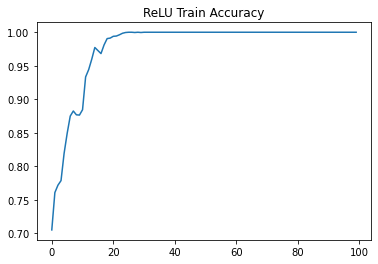

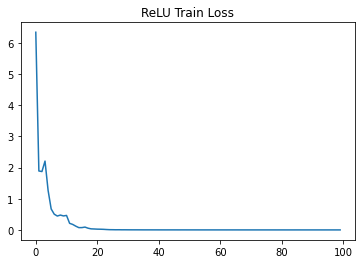

In [43]:
plt.title("ReLU Train Accuracy")
plt.plot(ta)
plt.show()

plt.title("ReLU Train Loss")
plt.plot(tl)
plt.show()

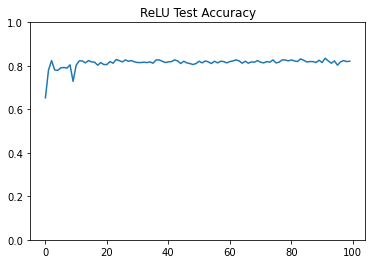

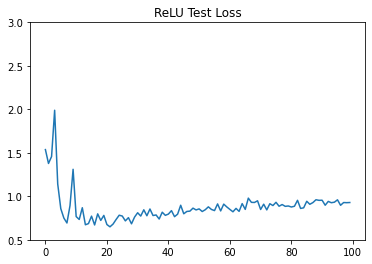

In [26]:
plt.title("ReLU Test Accuracy")
plt.ylim([0,1])
plt.plot(tea)
plt.show()

plt.title("ReLU Test Loss")
plt.ylim([0.5,3])
plt.plot(tel)
plt.show()

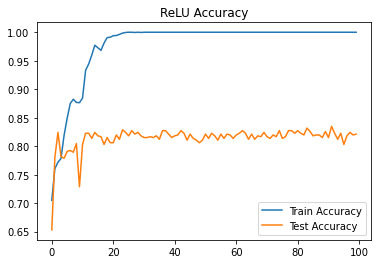

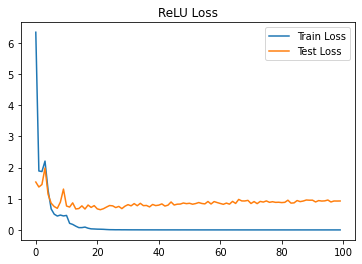

In [50]:
plt.title('ReLU Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('ReLU Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [18]:
checkpoint = torch.load('best_checkpoint_relu.model')

In [19]:
model = ConvNet(num_classes=2)

In [20]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [21]:
from prettytable import PrettyTable

In [22]:
def count_parameters(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [23]:
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    324     |
|  conv1.bias  |     12     |
|  bn1.weight  |     12     |
|   bn1.bias   |     12     |
| conv2.weight |    2160    |
|  conv2.bias  |     20     |
| conv3.weight |    5760    |
|  conv3.bias  |     32     |
|  bn3.weight  |     32     |
|   bn3.bias   |     32     |
|  fc.weight   |   360000   |
|   fc.bias    |     2      |
+--------------+------------+
Total Trainable Params: 368398


368398

In [26]:
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 
                                                                    'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         336                       [3, 3]                    7,560,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─ReLU: 1-3                              [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 20, 75, 75]           2,180

In [15]:
# Using Dropouts

class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75*75*32,out_features=num_classes)
        self.dropout = nn.Dropout(0.50)

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=self.dropout(output)
        #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        
        return output

In [16]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        test_loss+= loss.cpu().data*images.size(0)        
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_relu.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(8.2435) Train Accuracy: 0.7023132347364429 Test Accuracy: 0.5681818181818182
Epoch: 1 Train Loss: tensor(2.2236) Train Accuracy: 0.7781569965870307 Test Accuracy: 0.6151515151515151
Epoch: 2 Train Loss: tensor(1.9384) Train Accuracy: 0.7732271520667425 Test Accuracy: 0.7924242424242425
Epoch: 3 Train Loss: tensor(1.9642) Train Accuracy: 0.7705726204019719 Test Accuracy: 0.7818181818181819
Epoch: 4 Train Loss: tensor(1.1556) Train Accuracy: 0.819491846795601 Test Accuracy: 0.806060606060606
Epoch: 5 Train Loss: tensor(0.4956) Train Accuracy: 0.8543799772468714 Test Accuracy: 0.8015151515151515
Epoch: 6 Train Loss: tensor(0.3317) Train Accuracy: 0.8729616989002654 Test Accuracy: 0.7984848484848485
Epoch: 7 Train Loss: tensor(0.3055) Train Accuracy: 0.8892681076981418 Test Accuracy: 0.8090909090909091
Epoch: 8 Train Loss: tensor(0.2282) Train Accuracy: 0.9177095183921122 Test Accuracy: 0.8075757575757576
Epoch: 9 Train Loss: tensor(0.2292) Train Accuracy: 0.908

Epoch: 85 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8045454545454546
Epoch: 86 Train Loss: tensor(0.0006) Train Accuracy: 1.0 Test Accuracy: 0.8136363636363636
Epoch: 87 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8136363636363636
Epoch: 88 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8196969696969697
Epoch: 89 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8166666666666667
Epoch: 90 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8106060606060606
Epoch: 91 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8257575757575758
Epoch: 92 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8196969696969697
Epoch: 93 Train Loss: tensor(0.0009) Train Accuracy: 1.0 Test Accuracy: 0.8136363636363636
Epoch: 94 Train Loss: tensor(0.0005) Train Accuracy: 1.0 Test Accuracy: 0.803030303030303
Epoch: 95 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8212121212121212


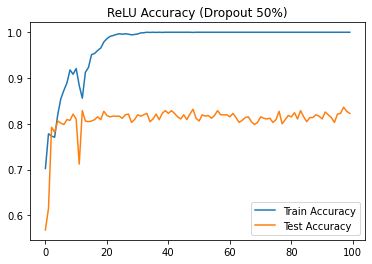

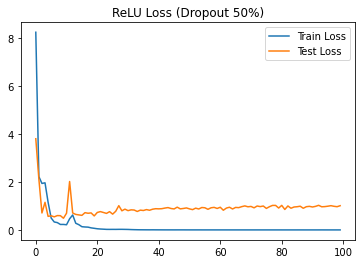

In [17]:
plt.title('ReLU Accuracy (Dropout 50%)')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('ReLU Loss (Dropout 50%)')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

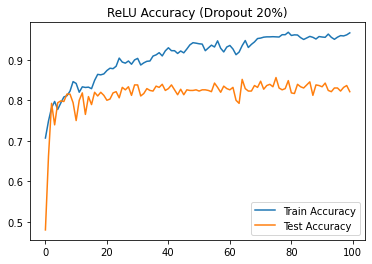

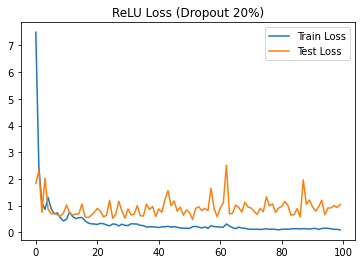

In [22]:
plt.title('ReLU Accuracy (Dropout 20%)')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('ReLU Loss (Dropout 20%)')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [27]:
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    324     |
|  conv1.bias  |     12     |
|  bn1.weight  |     12     |
|   bn1.bias   |     12     |
| conv2.weight |    2160    |
|  conv2.bias  |     20     |
| conv3.weight |    5760    |
|  conv3.bias  |     32     |
|  bn3.weight  |     32     |
|   bn3.bias   |     32     |
|  fc.weight   |   360000   |
|   fc.bias    |     2      |
+--------------+------------+
Total Trainable Params: 368398


368398

In [28]:
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 
                                                                    'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         336                       [3, 3]                    7,560,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─ReLU: 1-3                              [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 20, 75, 75]           2,180